In [32]:
import matplotlib.pyplot as plt
import numpy as np

import pre_processing as pre_pro
import correlations as corr

## Retrieving data

In [2]:
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers
from epigenomic_dataset import active_promoters_vs_inactive_promoters

In [62]:
enhancers, enhancers_labels = active_enhancers_vs_inactive_enhancers(cell_line='A549')
promoters, promoters_labels = active_promoters_vs_inactive_promoters(cell_line='A549')

epigenomes = {
    "promoters": promoters,
    "enhancers": enhancers
}

labels = {
    "promoters": promoters_labels,
    "enhancers": enhancers_labels
}

In [63]:
enhancers.describe()

chrom,PBX1,HOXB5,CTCF,NR5A2,POLR2AphosphoS2,FOSL2,CBX8,REST,ATAC-seq,JUN,...,HOXB13,DNase-seq,CEBPB,RNF2,MYC,RFX5,CHD2,HOXA7,SIN3A,CHD4
count,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,...,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000,63285.000000
mean,0.958972,0.913036,1.209956,0.973173,0.913585,1.649383,0.784756,0.824127,1.559501,1.128004,...,0.867849,0.409369,1.555871,0.840282,0.963023,0.993750,0.985979,0.778543,1.118602,0.892104
std,1.682574,0.653761,3.790173,0.968981,0.872721,3.299778,0.406876,0.907664,2.136066,0.744430,...,0.558791,1.452805,3.320334,0.715002,0.789865,4.592618,0.828565,0.447260,0.986635,0.520470
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.480000,0.520000,0.420000,0.530000,0.460000,0.520000,0.540000,0.540000,0.470000,0.640000,...,0.510000,0.030000,0.460000,0.440000,0.500000,0.610000,0.590000,0.500000,0.610000,0.550000
50%,0.750000,0.800000,0.630000,0.790000,0.740000,0.810000,0.730000,0.750000,0.820000,1.010000,...,0.780000,0.060000,0.790000,0.720000,0.800000,0.860000,0.890000,0.710000,0.890000,0.810000
75%,1.100000,1.150000,0.900000,1.140000,1.120000,1.290000,0.960000,0.990000,1.530000,1.470000,...,1.100000,0.150000,1.320000,1.070000,1.200000,1.160000,1.250000,0.980000,1.280000,1.130000
max,165.590000,36.510000,101.000000,42.330000,32.560000,82.550000,16.220000,53.750000,20.270000,32.950000,...,13.710000,38.710000,94.530000,31.490000,21.020000,543.970000,81.120000,15.450000,31.220000,11.940000


## Labels

### Sbilanciamento delle classi

In the following cell we show the histograms of the TPMs for the two considered cis-regulatory regions.

In both cases, most of the samples are very close to 0, but the range of the two datasets samples is extremely different: while in the enhancers most values fall within a bin from 0 to 20, the promoters fall within a bin from 0 to 5000. The clear presence of outliers in both datasets will make it necessary, in the context of the regression task, to clip the outliers values to a given maximal value.

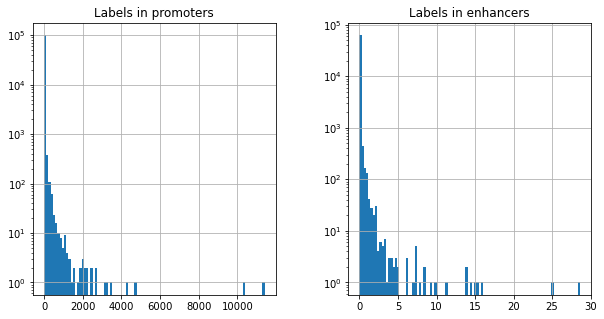

In [71]:
bins = 100
fig, axes = plt.subplots(ncols=len(labels), figsize=(10, 5))

for axis, (region, lbl) in zip(axes, labels.items()):
    lbl.hist(ax = axis, bins = bins, log = True)
    axis.set_title('Labels in ' + region)

In [104]:
print(promoters_labels.describe())
print('-'*20)
print(enhancers_labels.describe())

               A549
count  99881.000000
mean       4.989571
std       68.457689
min        0.000000
25%        0.000000
50%        0.000000
75%        0.553579
max    11402.760776
--------------------
               A549
count  63285.000000
mean       0.025651
std        0.277362
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       28.624352


### Soglie 

In [126]:
def threshold_imbalance(pro_thre:int, enh_thre:int) -> tuple:
    rate1 = (promoters_labels['A549']> pro_thre).mean()
    rate2 = (enhancers_labels['A549']> enh_thre).mean()
    
    return ('promoters_rate: ' + str(rate1),'enhancers_rate: '+ str(rate2))

In [127]:
threshold_imbalance(5, 0)

('promoters_rate: 0.10314273986043392', 'enhancers_rate: 0.05693292249348187')

In [128]:
threshold_imbalance(1, 1)

('promoters_rate: 0.20401277520249098', 'enhancers_rate: 0.003681757130441653')

## Pre-processing

In [64]:
pre_pro.rate_samples_features(epigenomes)

The rate between samples and features for promoters data is: 2080.8541666666665
--------------------------------------------------------------------------------
The rate between samples and features for enhancers data is: 1318.4375
--------------------------------------------------------------------------------


In [65]:
# NaN values

for region, x in epigenomes.items():
    print("\n".join((
        f"Nan values report for {region} data:\n",
        f"- In the document there are {x.isna().values.sum()} NaN values out of {x.values.size} values.",
        f"  % nan/totale = {x.isna().values.sum()/x.values.size*100}.",
        f"- The sample (row) with most values has {x.isna().sum(axis=1).max()} NaN values out of {x.shape[1]} values.",
        f"- The feature (column) with most values has {x.isna().sum().max()} NaN values out of {x.shape[0]} values.",
        f"- % nan_col_values/tot_samples = {x.isna().sum().max()/x.shape[0]*100}"
    )))
    print("-"*80)

Nan values report for promoters data:

- In the document there are 372 NaN values out of 4794288 values.
  % nan/totale = 0.007759233487850542.
- The sample (row) with most values has 2 NaN values out of 48 values.
- The feature (column) with most values has 189 NaN values out of 99881 values.
- % nan_col_values/tot_samples = 0.18922517796177452
--------------------------------------------------------------------------------
Nan values report for enhancers data:

- In the document there are 32 NaN values out of 3037680 values.
  % nan/totale = 0.0010534355165784414.
- The sample (row) with most values has 1 NaN values out of 48 values.
- The feature (column) with most values has 32 NaN values out of 63285 values.
- % nan_col_values/tot_samples = 0.05056490479576519
--------------------------------------------------------------------------------


In [66]:
# I valori NaN vengono sostituiti tramite KNN

for region, x in epigenomes.items():
    epigenomes[region] = pre_pro.knn_imputer(x)

#### Eliminazione features costanti

In [67]:
for region, x in epigenomes.items():
    result = pre_pro.drop_constant_features(x)
    if x.shape[1] != result.shape[1]:
        print(f"Features in {region} were constant and had to be dropped!")
        epigenomes[region] = result
    else:
        print(f"No constant features were found in {region}!")

No constant features were found in promoters!
No constant features were found in enhancers!


#### Normalizzazione

Usiamo robust_scaler (sottraendo la mediana, non sensibile agli outlier, e dividendo per la sd tra il primo e il terzo quartile, è una versione migliore di z-scoring 

In [68]:
epigenomes = {
    region: pre_pro.robust_zscoring(x)
    for region, x in epigenomes.items()
}

## Correlazione con l'output


se le features non hanno nessun tipo di correlazione con l'output, possiamo pensare di eliminarle

In [13]:
p_value_threshold = 0.01 

# salvo le features non correlate all'interno del dict uncorrelated
uncorrelated = {
    region: set()
    for region in epigenomes
}

#### Correlazione lineare di Pearson

In [14]:
corr.output_correlation('pearson', epigenomes, p_value_threshold, uncorrelated, labels)


Calcolo coefficiente di Pearson per promoters:

La feature ZC3H11A non è correlata in modo significativo con l'output, corr: -0.00021743447940157038
La feature PRDM1 non è correlata in modo significativo con l'output, corr: 0.007639434842807909
La feature EHMT2 non è correlata in modo significativo con l'output, corr: 0.003373545879994956
La feature FOSB non è correlata in modo significativo con l'output, corr: 0.0072934610937671895
La feature SREBF2 non è correlata in modo significativo con l'output, corr: 0.006681096810455964
La feature FOXF2 non è correlata in modo significativo con l'output, corr: 0.0020626623301107975
La feature RFX5 non è correlata in modo significativo con l'output, corr: 0.007223260400821491
La feature CHD4 non è correlata in modo significativo con l'output, corr: 0.0008994964099302842

Calcolo coefficiente di Pearson per enhancers:

La feature ZC3H11A non è correlata in modo significativo con l'output, corr: 0.002585249345050187
La feature CBX2 non è correlat

#### Correlazione monotona di Spearman

In [15]:
corr.output_correlation('spearman', epigenomes, p_value_threshold, uncorrelated, labels)


Calcolo coefficiente di Pearson per promoters:


Calcolo coefficiente di Pearson per enhancers:

La feature CBX2 non è correlata in modo significativo con l'output, corr: -0.0011977744523758835
La feature KDM5A non è correlata in modo significativo con l'output, corr: -0.003756719176732011


In [16]:
# minepy per Windows non vabbene

#### Elimino features non correlate con l'output

In [17]:
for region, x in epigenomes.items():
    epigenomes[region] =x.drop(columns=[
        col
        for col in uncorrelated[region]
        if col in x.columns
    ])

## Correlazione tra features


se le features non hanno nessun tipo di correlazione con l'output, possiamo pensare di eliminarle

In [18]:
correlation_threshold = 0.95

extremely_correlated = {
    region: set()
    for region in epigenomes
}

scores = {
    region: []
    for region in epigenomes
}

#### Correlazione lineare di Pearson

In [20]:
corr.features_correlation(
    'pearson', epigenomes, p_value_threshold, correlation_threshold, extremely_correlated, scores)

Running Pearson test for promoters:   0%|                                                       | 0/40 [00:00<…

Running Pearson test for enhancers:   0%|                                                       | 0/44 [00:00<…

#### Correlazione monotona di Spearman

In [26]:
corr.features_correlation(
    'spearman', epigenomes, p_value_threshold, correlation_threshold, extremely_correlated, scores)

Running Pearson test for promoters:   0%|                                                       | 0/40 [00:00<…

Running Pearson test for enhancers:   0%|                                                       | 0/44 [00:00<…

In [30]:
# non ci sono features altamente correlate
extremely_correlated

{'promoters': set(), 'enhancers': set()}

In [33]:
# Ordine le correlazioni in modo decrescente
scores = {
    region:sorted(score, key=lambda x: np.abs(x[0]), reverse=True)
    for region, score in scores.items()
}

In [ ]:
import seaborn as sns
import pandas as pd 

for region, x in epigenomes.items():
    _, firsts_feat, seconds_feat = list(zip(*scores[region][:3]))
    columns = list(set(firsts_feat + seconds_feat))
    print(f'Most correlated features from {region}')
    sns.pairplot(pd.concat([
        x[columns],
        labels[region],
    ], axis=1), hue=labels[region].columns[0])
    plt.show()

In [50]:
import pandas as pd
_, firsts, seconds = list(zip(*scores[region][:3]))
columns = list(set(firsts+seconds))


pd = pd.concat([ x[columns], labels[region]],  axis=1)
x[columns]
pd

ATAC-seq     RAD21  DNase-seq      CTCF  \
chrom chromStart chromEnd  strand                                            
chr10 100006381  100006637 .       5.632075  0.187500  19.750000  0.354167   
      100008146  100008402 .       0.103774  0.218750   1.000000  0.562500   
      100014418  100014674 .      -0.349057  0.281250   0.000000  0.312500   
      100020216  100020472 .       5.641509  0.843750  18.833333  1.083333   
      100043528  100043784 .       0.754717  0.640625   1.916667  3.833333   
...                                     ...       ...        ...       ...   
chrY  7520247    7520503   .      -0.641509 -0.187500  -0.416667 -0.854167   
      7724272    7724528   .      -0.641509 -0.640625  -0.416667 -0.750000   
      7770029    7770285   .      -0.566038 -0.890625  -0.416667 -0.916667   
      7796295    7796551   .      -0.584906 -1.140625  -0.500000 -0.979167   
      8007562    8007818   .      -0.641509 -0.015625  -0.416667 -0.791667   

                                       SMC3      A549  
chrom chromStart chromEnd  strand                      
chr10 100006381  100006637 .       0.625000  0.223628  
      100008146  100008402 .      -0.388889  0.000000  
      100014418  100014674 .       0.694444  0.000000  
      100020216  100020472 .       0.111111  0.000000  
      100043528  100043784 .       0.250000  0.000000  
...                                     ...       ...  
chrY  7520247    7520503   .      -0.888889  0.000000  
      7724272    7724528   .      -0.902778  0.000000  
      7770029    7770285   .      -0.597222  0.000000  
      7796295    7796551   .      -1.263889  0.000000  
      8007562    8007818   .      -0.486111  0.000000  

[63285 rows x 6 columns]